<a href="https://colab.research.google.com/github/davidfox87/neuro_encoding_models/blob/master/how_to_find_optimal_filter_length_behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
#@title Clone the github repository 
!git clone https://github.com/davidfox87/neuro_encoding_models
%cd neuro_encoding_models/


Cloning into 'neuro_encoding_models'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 401 (delta 219), reused 228 (delta 101), pack-reused 0
Receiving objects: 100% (401/401), 6.48 MiB | 24.11 MiB/s, done.
Resolving deltas: 100% (219/219), done.
/content/neuro_encoding_models/neuro_encoding_models/neuro_encoding_models


In [170]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [171]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
import utils.read as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from glmtools.fit import fit_nlin_hist1d
import pickle

In [172]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg = agg.fillna(0)
		# agg.dropna(inplace=True)
	return agg


In [173]:

# All you need in a Pipeline is any object with a fit and transform method
# that returns an array and takes the right positional arguments
# (array x, one-d optional array y)

class InsertLags(BaseEstimator, TransformerMixin):
	"""
    Automatically Insert Lags
    """

	def __init__(self, lag=1):
		self.lag = lag

	def fit(self, X, y=None):
		return self

	def transform(self, X, y=None):
		X = series_to_supervised(X, n_in=self.lag)
		return X.values



In [206]:
behaviors = ["angvturns", "vmoves", "vymoves"]
behavior_par = behaviors[0]

# load the data from MATLAB .mat file
stim, response = io.load_behavior('datasets/behavior/control_stim_to_behavior.mat', 30., 55., behavior_par, 50)
response = response.mean(axis=1)  # work on the fly-average
stim = stim[:, 0]
fs = 50

In [207]:
# consider splitting by 80/20 train/validation and then make a lot of timeseries splits > 10, then test the mse on test
stim_train, stim_test, resp_train, resp_test = train_test_split(stim, response,
	 																test_size=0.001,
																	shuffle=False,
																	random_state=42)
scaler = MinMaxScaler([0, 1])
resp_train_scaled = scaler.fit_transform(resp_train.reshape(-1, 1))

print(stim_train.shape)
print(stim_test.shape)

(1248,)
(2,)


In [208]:
estimators = [('add_lags', InsertLags()),
				  ('scaler', StandardScaler()),
				  ('model', Ridge(fit_intercept=False))]

pipe = Pipeline(steps=estimators)
alphas = np.logspace(0, 20, num=10, base=2)

param_grid = {
	'model__alpha': alphas,
	'add_lags__lag': [1*fs, 2*fs, 4*fs, 8*fs, 10*fs, 12*fs]
}

tscv = TimeSeriesSplit(n_splits=10)
search = GridSearchCV(pipe, param_grid=param_grid, cv=tscv, verbose=1,
						  scoring='neg_mean_squared_error', n_jobs=-1,
						  return_train_score=True)

search.fit(stim_train.reshape(-1, 1), resp_train_scaled)


Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('add_lags', InsertLags(lag=1)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=False,
                                              max_iter=None, normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                ve...
             iid='deprecated', n_jobs=-1,
             param_grid={'add_lags__lag': [

In [209]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
	print("%0.3f (+/-%0.03f) for %r"
			  % (mean, std * 2, params))

print("Best: %f using %s" % (search.best_score_, search.best_params_))

res = [sub['add_lags__lag'] for sub in search.cv_results_['params']]
df = pd.DataFrame({'rmse': means, 'window_length': res})


-0.192 (+/-0.051) for {'add_lags__lag': 50, 'model__alpha': 1.0}
-0.188 (+/-0.049) for {'add_lags__lag': 50, 'model__alpha': 4.666116158304467}
-0.183 (+/-0.052) for {'add_lags__lag': 50, 'model__alpha': 21.772640002790034}
-0.180 (+/-0.059) for {'add_lags__lag': 50, 'model__alpha': 101.59366732596479}
-0.180 (+/-0.063) for {'add_lags__lag': 50, 'model__alpha': 474.0478526910928}
-0.184 (+/-0.073) for {'add_lags__lag': 50, 'model__alpha': 2211.9623452514425}
-0.190 (+/-0.088) for {'add_lags__lag': 50, 'model__alpha': 10321.273240738805}
-0.193 (+/-0.098) for {'add_lags__lag': 50, 'model__alpha': 48160.25984288687}
-0.194 (+/-0.101) for {'add_lags__lag': 50, 'model__alpha': 224721.36664103606}
-0.194 (+/-0.102) for {'add_lags__lag': 50, 'model__alpha': 1048576.0}
-0.189 (+/-0.075) for {'add_lags__lag': 100, 'model__alpha': 1.0}
-0.184 (+/-0.074) for {'add_lags__lag': 100, 'model__alpha': 4.666116158304467}
-0.179 (+/-0.075) for {'add_lags__lag': 100, 'model__alpha': 21.772640002790034}


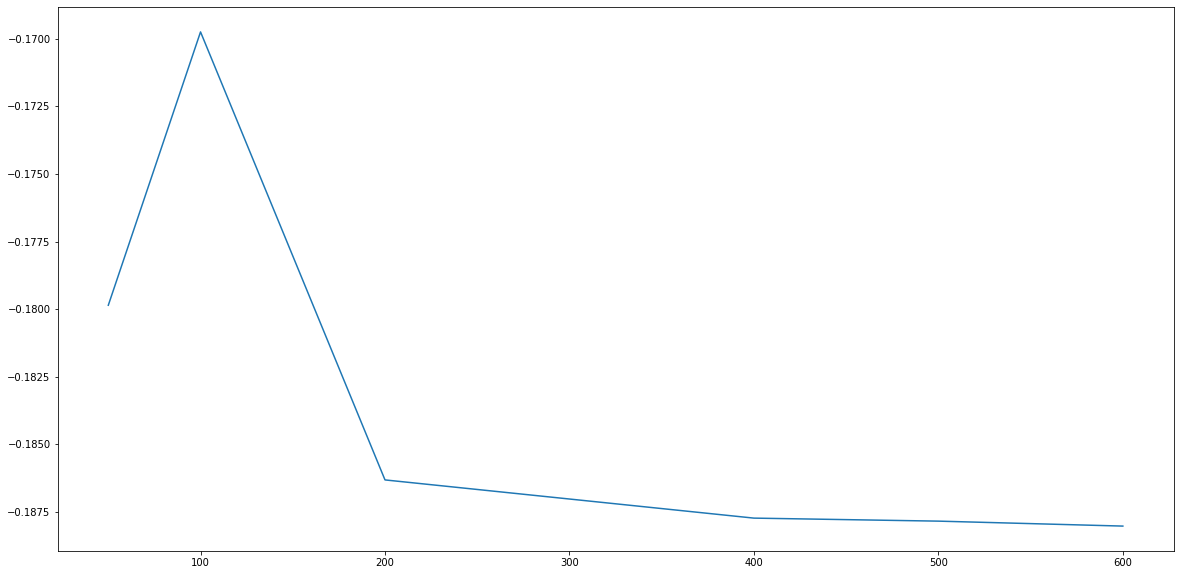

In [210]:
# plot the neg_mean_squared_error as a function of window length
# plt.figure()
df2 = df.groupby('window_length').agg(['max'])

plt.figure()
plt.plot(df2)

In [211]:
df2.shape

(6, 1)

In [212]:
estimators = [('add_lags', InsertLags(search.best_params_['add_lags__lag'])),
				  ('scaler', StandardScaler()),
				  ('model', Ridge(search.best_params_['model__alpha']))]
pipe = Pipeline(steps=estimators)

# scale the output
pipe.fit(stim_train.reshape(-1, 1), resp_train_scaled)


Pipeline(memory=None,
         steps=[('add_lags', InsertLags(lag=100)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=474.0478526910928, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

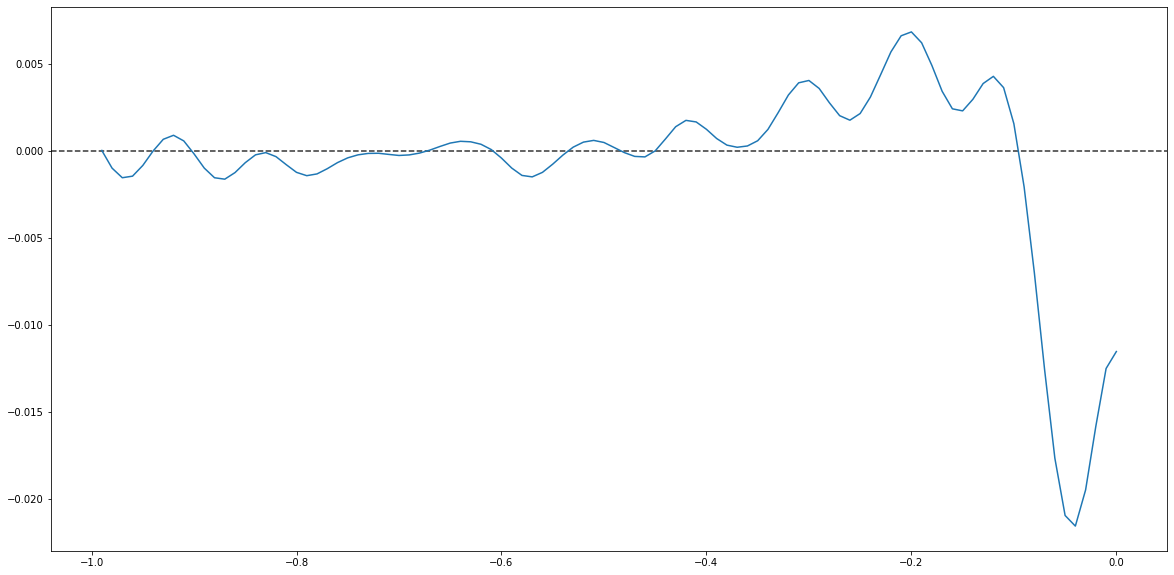

In [213]:
plt.figure()
w = pipe.named_steps['model'].coef_[0]
d = len(w[1:])
t = np.arange(-d + 1, 1) * 0.01
plt.plot(t, w[1:])
plt.axhline(0, color=".2", linestyle="--", zorder=1)


In [214]:
w.shape
stim_train = stim_train.squeeze()

In [215]:
resp_train = resp_train.squeeze()

In [183]:
#resp_train.shape
stim_train.shape

(1248,)

In [216]:
plt.figure()
w.shape
xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim_train, resp_train, w, 0.01, 50)


<Figure size 1440x720 with 0 Axes>

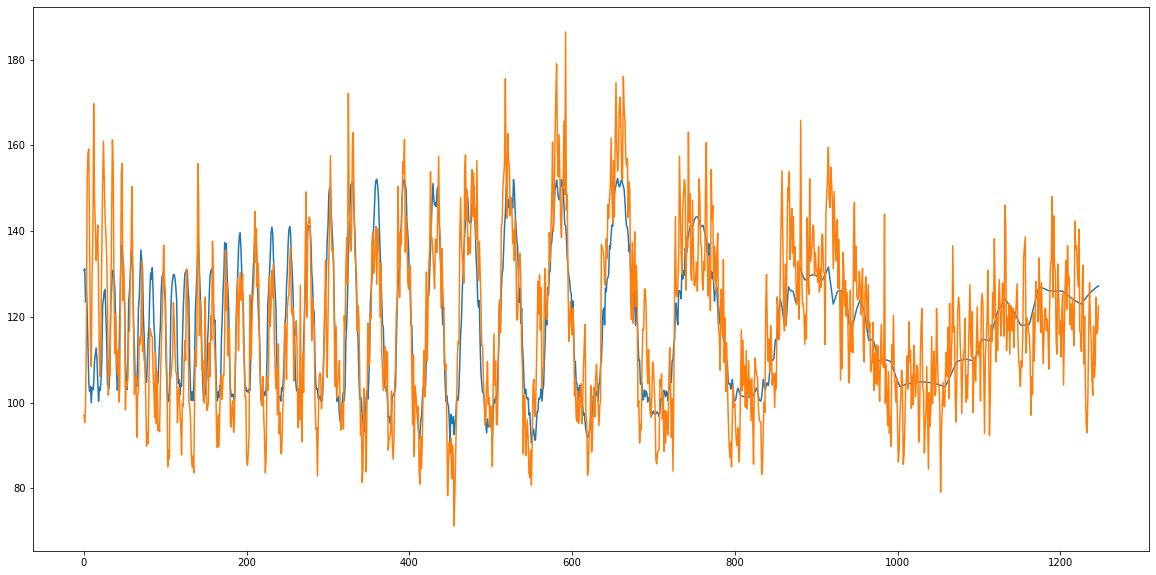

In [217]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(fnlin(rawfilteroutput))
plt.plot(resp_train)

In [219]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [227]:
file_name = "/content/gdrive/My Drive/" + behavior_par + "_filter.pkl"
data = {'name': behavior_par,
	 		'k': w[1:],
	 		'nlfun': (xx, fnlin(xx)),
			'window_length_mse': df2}
	
output = open(file_name, 'wb')
	
# pickle dictionary using protocol 0
pickle.dump(data, output)

In [226]:
data['window_length_mse']

,rmse
,max
window_length,
50,-0.179855
100,-0.169742
200,-0.186317
400,-0.187730
500,-0.187841
600,-0.188025


In [228]:
%ls -la /content/gdrive/My\ Drive

total 223527
-rw------- 1 root root  31003023 Jun 28 23:41  61507788835__40E57B85-A9E5-48B4-A20C-4D8AAE8B057B.MOV
-rw------- 1 root root      3957 Oct  5 23:05  angvturns_filter.pkl
drwx------ 2 root root      4096 Apr 21  2019 'Bread baking'/
-rw------- 1 root root       151 Aug 26 03:30  budget2020.gsheet
-rw------- 1 root root 122950541 Jan 23  2015  Codes.tar.gz
drwx------ 2 root root      4096 Jul 13 19:10 'Colab Notebooks'/
-rw------- 1 root root       151 May 28 02:45 'Copy of DavidFoxResume.gdoc'
-rw------- 1 root root       151 Jul 31 20:16 'Copy of NMA-pod151-presentation.gslides'
-rw------- 1 root root   1731160 May 10  2019 'Copy operation sheet.pdf'
-rw------- 1 root root     16653 Jul  7 14:06  DavidFoxResumeLatest.docx
-rw------- 1 root root        19 Aug 26 03:56  foo.txt
-rw------- 1 root root     89578 Apr 19 22:41  Fox_resume_04_19_2020.pdf
drwx------ 2 root root      4096 Nov 19  2019 'Green Card Application'/
drwx------ 2 root root      4096 Jan 13  2019 'Health St